# DDQN Agent in Lunar Lander Version 2

To run this code safely do it in google colab and comment out anything that saves plots or agent's networks to google drive.

### Create QNetwork Class

Here we create a QNetwork class that will be used for the agents target and online network, it also takes into account optional layers that will added during hyperparameter tuning later on.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64, fc3_units=0, fc4_units=0):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
            fc3_units (int): Number of nodes in third hidden layer (optional)
            fc4_units (int): Number of nodes in fourth hidden layer (optional)
        """
        super(QNetwork, self).__init__()

        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        if fc3_units != 0:
            self.fc3 = nn.Linear(fc2_units, fc3_units)
        if fc4_units != 0:
            self.fc4 = nn.Linear(fc3_units if fc3_units != 0 else fc2_units, fc4_units)
        self.fc5 = nn.Linear((fc4_units if fc4_units != 0 else fc3_units if fc3_units != 0 else fc2_units), action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        if hasattr(self, "fc3"):
            x = F.relu(self.fc3(x))
        if hasattr(self, "fc4"):
            x = F.relu(self.fc4(x))
        return self.fc5(x)

### Create Replay Buffer

In [3]:
import numpy as np
import random
from collections import namedtuple, deque

import torch

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(
        self,
        action_size,
        buffer_size,
        batch_size,
        seed,
        device=torch.device(torch.device("cuda:0") if torch.cuda.is_available() else "cpu")
    ):
        """Initialize a ReplayBuffer object.
        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple(
            "Experience",
            field_names=["state", "action", "reward", "next_state", "done"],
        )
        self.seed = random.seed(seed)
        self.device = device

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = (
            torch.from_numpy(np.vstack([e.state for e in experiences if e is not None]))
            .float()
            .to(self.device)
        )
        actions = (
            torch.from_numpy(
                np.vstack([e.action for e in experiences if e is not None])
            )
            .long()
            .to(self.device)
        )
        rewards = (
            torch.from_numpy(
                np.vstack([e.reward for e in experiences if e is not None])
            )
            .float()
            .to(self.device)
        )
        next_states = (
            torch.from_numpy(
                np.vstack([e.next_state for e in experiences if e is not None])
            )
            .float()
            .to(self.device)
        )
        dones = (
            torch.from_numpy(
                np.vstack([e.done for e in experiences if e is not None]).astype(
                    np.uint8
                )
            )
            .float()
            .to(self.device)
        )

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### Download Necessary Packages

In [ ]:
import sys
!{sys.executable} -m pip install gymnasium
!{sys.executable} -m pip install optuna
!{sys.executable} -m pip install gymnasium[box2d]

### Create DDQN Agent Class

In [5]:
class DDQNAgent:
    def __init__(
        self,
        state_size,
        action_size,
        seed,
        loss_fn,
        buffer_size=10000,
        batch_size=64,
        fc1_units=64,
        fc2_units=64,
        fc3_units=0,
        fc4_units=0,
        gamma=0.99,
        tau=1e-3,
        lr=5e-4,
        update_every=4,
        # this is used in the training loop but we want to see how a change in this can affect traning so need to be here for optune optimizer
        eps_decay=0.995,
        device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    ):
        self.num_exploitative_actions = 0
        self.loss_fn = loss_fn
        self.eps_decay = eps_decay
        self.num_exploratory_actions = 0
        self.loss = 0.0
        self.device = device
        self.state_size = state_size
        self.action_size = action_size
        self.seed = seed
        self.gamma = gamma
        self.tau = tau
        self.lr = lr
        self.update_every = update_every
        self.steps_done = 0
        self.online_network = QNetwork(
            state_size, action_size, self.seed, fc1_units, fc2_units, fc3_units=fc3_units, fc4_units=fc4_units
        ).to(self.device)
        self.target_network = QNetwork(
            state_size, action_size, self.seed, fc1_units, fc2_units, fc3_units=fc3_units, fc4_units=fc4_units
        ).to(self.device)
        self.optimizer = torch.optim.Adam(self.online_network.parameters(), lr=self.lr)
        self.memory = ReplayBuffer(action_size, buffer_size, batch_size, self.seed)
        self.batch_size = batch_size
        self.update_counter = 0

    def step(self, state, action, reward, next_state, done):
        """Updates the agent's experience replay memory and performs a learning step if enough samples are available.

        Params
        ======
            state (array_like): the current state of the environment
            action (int): the action taken by the agent in the current state
            reward (float): the reward received for taking the action in the current state
            next_state (array_like): the next state of the environment after taking the action
            done (bool): a flag indicating whether the episode has terminated
        """
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)

        # Learn every UPDATE_EVERY time steps.
        self.update_counter = (self.update_counter + 1) % self.update_every
        if self.update_counter == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > self.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences, self.gamma)

    def act(self, state, eps=0.0):
        """Returns actions for given state as per current policy.

        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        self.online_network.eval()
        with torch.no_grad():
            action_values = self.online_network(state)
        self.online_network.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            self.num_exploitative_actions += 1
            return np.argmax(action_values.cpu().data.numpy())
        else:
            self.num_exploratory_actions += 1
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from online model
        q_online = self.online_network(next_states).detach()
        best_actions = torch.argmax(q_online, dim=1)
        q_target = self.target_network(next_states).detach()
        Q_targets_next = q_target[range(self.batch_size), best_actions]
        Q_targets_next = Q_targets_next.unsqueeze(1)

        # Compute Q targets for current states
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.online_network(states).gather(1, actions)

        # Compute loss - only two options and if it is not mse it is huber loss
        loss = (
            F.mse_loss(Q_expected, Q_targets)
            if self.loss_fn == "mse"
            else F.huber_loss(Q_expected, Q_targets)
        )
        self.loss += loss.item()
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.update_target_network()

    def update_target_network(self):
        """Update the target network to have the same weights as the online network."""
        for target_param, online_param in zip(
            self.target_network.parameters(), self.online_network.parameters()
        ):
            target_param.data.copy_(
                self.tau * online_param.data + (1.0 - self.tau) * target_param.data
            )

### Create Utility Functions to Train Agent

In [13]:
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner
# comment out if not on google colab
from google.colab import drive
import cv2
import matplotlib.pyplot as plt
import pandas as pd

# comment out if not on google colab
drive.mount('/content/drive')

def save_metric_plots_to_drive(metrics, trial, save_location='/content/drive/My Drive/RLCW', agent_type='ddqn'):
    """Saves plots of the given metrics to the specified location on Google Drive.

    Params
    ======
        metrics (dict): a dictionary containing the metrics to plot, where the keys are the names of the metrics and the values are the metric values over time
        trial (Trial): the Optuna trial object for which the metrics are being saved
        save_location (str, optional): the location on Google Drive where the plots should be saved. Default is '/content/drive/My Drive/RLCW'
        agent_type (str, optional): the type of agent for which the metrics are being saved. Default is 'ddqn'
    """
    title = lambda x: x.replace("_", " ").title()
    for key, metric in metrics.items():
        # clear plot so others don't get saved in same img
        plt.clf()
        key_title = title(key)
        plt.plot(metric)
        plt.plot(pd.Series(metric).rolling(100, min_periods=0).mean(), label="Rolling Mean (100)")
        plt.xlabel("Episodes")
        plt.ylabel(key_title)
        plt.title(key_title + " over time")
        plt.savefig(f"{save_location}/{agent_type}/models/trial_{trial.number}/{agent_type}_{key}", bbox_inches="tight")
        # clear plot so others don't get saved in same img
        plt.clf()

def train_agent(
    agent,
    env,
    agent_type,
    trial,
    n_episodes=1000,
    max_t=1000,
    eps_start=1.0,
    eps_end=0.01,
    save_agent=False,
    save_metrics=True,
    save_location='/content/drive/My Drive/RLCW',
):
    """Trains the given agent in the given environment.

    Params
    ======
        agent (Agent): the agent to be trained
        env (gym.Env): the environment in which the agent should be trained
        agent_type (str): the type of agent being trained
        trial (Trial): the Optuna trial object for which the agent is being trained
        n_episodes (int, optional): the number of episodes to train the agent for. Default is 1000
        max_t (int, optional): the maximum number of time steps allowed per episode. Default is 1000
        eps_start (float, optional): the initial value for epsilon in the epsilon-greedy action selection. Default is 1.0
        eps_end (float, optional): the final value for epsilon in the epsilon-greedy action selection. Default is 0.01
        save_agent (bool, optional): a flag indicating whether the trained agent should be saved. Default is False
        save_location (str, optional): the location on Google Drive where the trained agent should be saved. Default is '/content/drive/My Drive/RLCW'
    Returns:
    ======
        rolling_100_mean_scores (list): contains mean scores taken from a rolling 100 window
    """
    
    scores = []
    episode_lengths = []
    losses = []
    exploitative_actions = []
    exploratory_actions = []
    rolling_100_mean_scores = []

    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start  # initialize epsilon
    eps_change = [eps]

    for i_episode in range(1, n_episodes + 1):
        state, _ = env.reset()
        score = 0
        episode_length = 0
        for _ in range(max_t):

            # Increment the episode length counter
            episode_length += 1

            action = agent.act(state, eps)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated | truncated
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward

            if done:
                break

        # save total loss during the episode and reset it
        losses.append(agent.loss)
        agent.loss = 0

        exploitative_actions.append(agent.num_exploitative_actions)
        agent.num_exploitative_actions = 0

        exploratory_actions.append(agent.num_exploratory_actions)
        agent.num_exploratory_actions = 0

        episode_lengths.append(episode_length)

        scores_window.append(score)  # save most recent score
        scores.append(score)  # save most recent score

        eps = max(eps_end, agent.eps_decay * eps)  # decrease epsilon
        eps_change.append(eps)

        rolling_100_mean = np.mean(scores_window)
        
        print(
            "\rEpisode {}\tAverage Score: {:.2f}".format(
                i_episode, rolling_100_mean
            ),
            end="",
        )
        rolling_100_mean_scores.append(rolling_100_mean)
        if i_episode % 100 == 0:
            if save_agent:

                # Deserialize as to not keep updating this saved model since it will otherwise be a reference
                target_network = agent.target_network.state_dict()
                online_network = agent.online_network.state_dict()

                torch.save(target_network, f'{save_location}/{agent_type}/models/trial_{trial.number}/{agent_type}_target_network_{i_episode}.pth')
                torch.save(online_network, f'{save_location}/{agent_type}/models/trial_{trial.number}/{agent_type}_online_network_{i_episode}.pth')
            print(
                "\rEpisode {}\tAverage Score: {:.2f}".format(
                    i_episode, rolling_100_mean
                )
            )
        if rolling_100_mean >= 200.0:
            print(
                "\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}".format(
                    i_episode , rolling_100_mean
                )
            )
            
            if save_agent:
                solved_target_network = agent.target_network.state_dict()
                solved_online_network = agent.online_network.state_dict()

                # Comment out these lines if you want to train but are not running on google colab
                torch.save(solved_target_network, f'{save_location}/{agent_type}/models/trial_{trial.number}/{agent_type}_target_network_{i_episode}_solved.pth')
                torch.save(solved_online_network, f'{save_location}/{agent_type}/models/trial_{trial.number}/{agent_type}_online_network_{i_episode}_solved.pth')
            break

    metrics = {
        "scores": scores,
        "episode_lengths": episode_lengths,
        "losses": losses,
        "exploitative_actions": exploitative_actions,
        "exploratory_actions": exploratory_actions,
        "eps_change": eps_change,
        "rolling_100_mean_scores": rolling_100_mean_scores
    }
    if save_metrics:
        save_metric_plots_to_drive(metrics, trial)
    return rolling_100_mean_scores
    
def create_study(env, n_trials=30, n_episodes=1000, seed=42, save_location='/content/drive/My Drive/RLCW', agent_type='ddqn', save_agent=False):
    """ Conducts an Optuna study to tune the hyperparameters of an agent. The study maximizes the objective value,
    which is the average score over a rolling window of 100 episodes, and minimizes the number of episodes.
    It also plots graphs from the results of the study and saves them to the specified save location.

    Parameters:
    ======
        env (gym.Env): The environment to train the agent on.
        n_trials (int, optional): The number of trials to run in the study. Default is 30.
        n_episodes (int, optional): The number of episodes to train the agent for in each trial. Default is 1000.
        seed (int, optional): The seed value to use for the study. Default is 42.
        save_location (str, optional): The location to save the results of the study. Default is '/content/drive/My Drive/RLCW'.
        agent_type (str, optional): The type of agent to train. Default is 'ddqn'.
        save_agent (bool, optional): Whether to save the trained agent. Default is False.

    Returns:
    ======
        optuna.study.Study: The Optuna study object.
    """
    def objective(trial):
        # Sample hyperparameter values
        batch_size = trial.suggest_int("batch_size", 32, 256)
        fc1_units = trial.suggest_int("fc1_units", 16, 128)
        fc2_units = trial.suggest_int("fc2_units", 16, 128)

        optional_layer_1 = trial.suggest_categorical("include_optional_layer_1", [True, False])
        optional_layer_2 = trial.suggest_categorical("include_optional_layer_2", [True, False])

        fc3_units = 0
        if optional_layer_1:
            fc3_units = trial.suggest_int("fc3_units", 16, 128) 

        fc4_units = 0
        if optional_layer_2:
            fc4_units = trial.suggest_int("fc4_units", 16, 128) 

        gamma = trial.suggest_float("gamma", 0.9, 1.0)
        lr = trial.suggest_float("lr", 1e-4, 1e-2)
        eps_decay = trial.suggest_float("eps_decay", 0.9, 0.999)
        tau = trial.suggest_float("tau", 1e-5, 1e-3)
        loss_fn = trial.suggest_categorical("loss_fn", ["mse", "huber"])
        
        # Create and train DDQN agent
        agent = (
            DDQNAgent(
                state_size=8,
                action_size=4,
                seed=seed,
                batch_size=batch_size,
                fc1_units=fc1_units,
                fc2_units=fc2_units,
                fc3_units=fc3_units,
                fc4_units=fc4_units,
                gamma=gamma,
                lr=lr,
                eps_decay=eps_decay,
                tau=tau,
                loss_fn=loss_fn,
            )
        )
        rolling_100_mean_scores = train_agent(agent, env, n_episodes=n_episodes, agent_type=agent_type, trial=trial, save_agent=save_agent)

        # Return average reward over all episodes and number of episodes 
        # Might want to use pd.Series(metrics["scores"]).rolling(100, min_periods=0).mean().mean()
        return rolling_100_mean_scores[-1], len(rolling_100_mean_scores) 

    study = optuna.create_study(
        study_name=f"{agent_type}_study",
        directions=["maximize", "minimize"],
        sampler=TPESampler(seed=seed),
        storage=None,
    )
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[0], target_name="Average Score")
    # Comment out line below if you want to run and not save to drive
    plt.savefig(f"{save_location}/{agent_type}/study_graphs/{agent_type}_optimization_history.png", bbox_inches="tight")
    plt.show()
    plt.clf()

    optuna.visualization.matplotlib.plot_slice(study, target=lambda t: t.values[0], target_name="Average Score")
    # Comment out line below if you want to run and not save to drive
    plt.savefig(f"{save_location}/{agent_type}/study_graphs/{agent_type}_plot_slice.png", bbox_inches="tight")
    plt.show()
    plt.clf()

    optuna.visualization.matplotlib.plot_param_importances(study, target=lambda t: t.values[0], target_name="Average Score")
    # Comment out line below if you want to run and not save to drive
    plt.savefig(f"{save_location}/{agent_type}/study_graphs/{agent_type}_paramter_importance.png", bbox_inches="tight")
    plt.show()
    plt.clf()

    return study

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Hyper Parameter Tuning

 Here we get attempt to explore the optimal hyperparameters to train the agent with

[I 2023-01-05 15:14:46,188] A new study created in memory with name: ddqn_study
/usr/local/lib/python3.8/dist-packages/optuna/progress_bar.py:49: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Episode 100	Average Score: -202.50
Episode 200	Average Score: -118.31
Episode 300	Average Score: -36.30
Episode 400	Average Score: -8.95
Episode 500	Average Score: 23.16
Episode 600	Average Score: 9.85
[I 2023-01-05 15:29:45,978] Trial 0 finished with values: [9.853967304718957, 600.0] and parameters: {'batch_size': 116, 'fc1_units': 123, 'fc2_units': 98, 'include_optional_layer_1': True, 'include_optional_layer_2': True, 'fc3_units': 113, 'fc4_units': 83, 'gamma': 0.9708072577796045, 'lr': 0.00030378649352844425, 'eps_decay': 0.9960210753640374, 'tau': 0.0008341182143924176, 'loss_fn': 'mse'}. 
Episode 100	Average Score: -257.82
Episode 200	Average Score: -399.59
Episode 300	Average Score: -213.02
Episode 400	Average Score: -427.36
Episode 500	Average Score: -279.79
Episode 600	Average Score: -247.55
[I 2023-01-05 15:31:50,639] Trial 1 finished with values: [-247.55106015544175, 600.0] and parameters: {'batch_size': 73, 'fc1_units': 50, 'fc2_units': 75, 'include_optional_layer_1': Tru

<ipython-input-13-2443c4f2de92>:243: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[0], target_name="Average Score")


<Figure size 432x288 with 0 Axes>

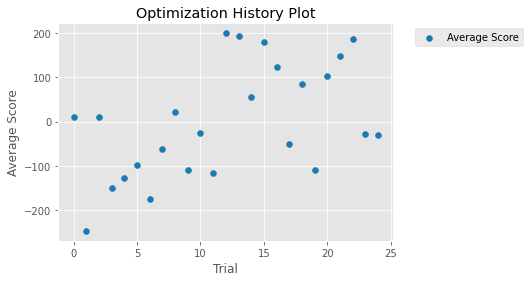

<ipython-input-13-2443c4f2de92>:249: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(study, target=lambda t: t.values[0], target_name="Average Score")


<Figure size 432x288 with 0 Axes>

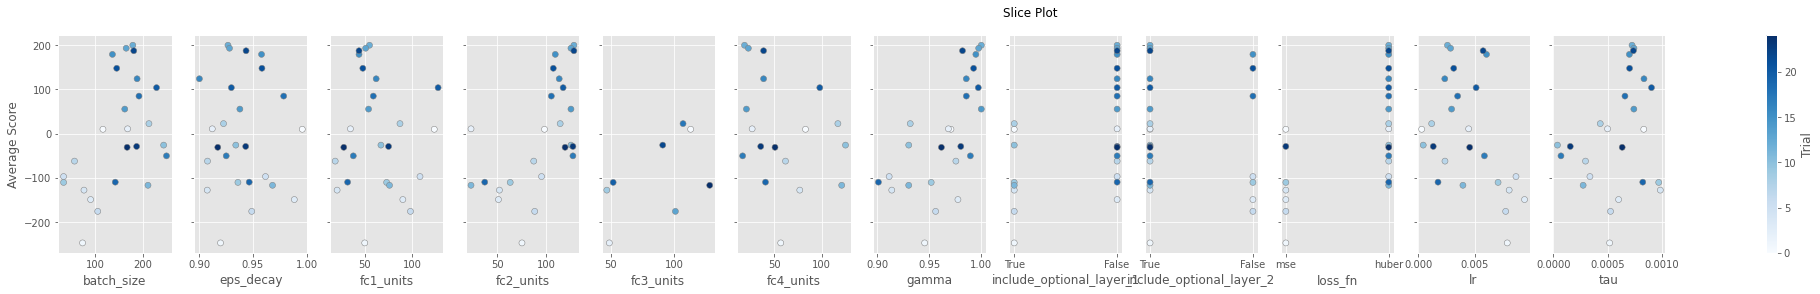

<ipython-input-13-2443c4f2de92>:255: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study, target=lambda t: t.values[0], target_name="Average Score")


<Figure size 432x288 with 0 Axes>

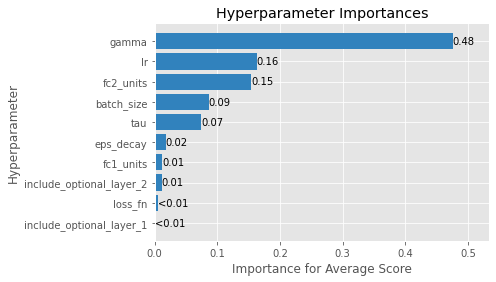

<Figure size 432x288 with 0 Axes>

In [14]:
import gymnasium as gym

n_trials = 25
n_episodes = 600
agent_type = "ddqn"
env = gym.make("LunarLander-v2")

study = create_study(
        env, n_trials=n_trials, n_episodes=n_episodes, agent_type=agent_type, save_agent=True
)

## IMPORTANT: Agent Videos
Googl Colab cannot render the environment so if you want to reproduce creating videos from saved optimal agent run the following file agent_videos.py. The saved models have been added from the drive folder where they were saved.

This is the best performing model that we will be using:

Trial 12 finished with values: [200.09690887725108, 429.0] and parameters: <br/><br/>
{'batch_size': 179, 'fc1_units': 55, 'fc2_units': 128, 'include_optional_layer_1': False, 'include_optional_layer_2': True, 'fc4_units': 19, 'gamma': 0.9999362438641551, 'lr': 0.0025872698903683716, 'eps_decay': 0.9266985052054595, 'tau': 0.0007259979059427554, 'loss_fn': 'huber'}. 